**Overview of Process**:<br>
1. Read data file and load libraries
2. Perform one hot encoding of column to change categorical into dummy variables
    a. Decision Tree<br>
    b. KNN<br>
    c. Logistic Regression<br>
    d. Naive Bayes<br>
    e. Support Vector Machine<br>
3. Nested cross validation
4. Comparison of predictive performance

In [15]:
# Create column names for pandas dataframe
column_names = ['buying','maint','doors','persons','lug_boot','safety','class']
# Read data set into pandas dataframe
data = pd.read_csv("car.data",names=column_names)
print("Dimension of data",data.shape)
data.head(5)

Dimension of data (1728, 7)


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


**Using one hot encoding of variables**

In [16]:
# One hot encoding and train test split
x=data[['buying','maint','doors','persons','lug_boot','safety']]
y=data['class']
x = pd.get_dummies(x, prefix_sep='_')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=123)

print("Train",x_train.shape)
print("Test",x_test.shape)
x.head()

Train (1382, 21)
Test (346, 21)


,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [2]:
# Create mode_fit function for decision tree, knn and logistic regression and SVM
# Calculate important metrics like testing accuracy, roc-auc, f1-measure
def model_fit(alg,x_train,x_test,y_train,y_test):
    #fit model
    alg.fit(x_train,y_train)
    
    #predict using model
    train_predictions=alg.predict(x_train)
    
    #print report
    print("Training Accuracy: ",round(metrics.accuracy_score(
        y_train.values,train_predictions),2))
        
    # Predict using testing dataset
    y_test_predict=alg.predict(x_test)
    y_test_predict_prob=alg.predict_proba(x_test)[:,1]
    y_test_predict_prob_both=alg.predict_proba(x_test)
    
    # Calculate accuracy score on predicted values
    print("Testing Accuracy: ", round(metrics.accuracy_score(
            y_test,y_test_predict),2)," \n")
    print("Kappa Statistic: ", round(metrics.cohen_kappa_score(
            y_test.values,y_test_predict),2)," \n")
    print("MCC: ", round(metrics.matthews_corrcoef(
            y_test.values,y_test_predict),2)," \n")
    print("Classification Report:")
    print(metrics.classification_report(y_test.values,
                                        y_test_predict))
    print("Confusion Matrix: ")
    print("Actual           Predicted")
    labels = list(unique_labels(y_test.values, y_test_predict))
    print(pd.DataFrame(metrics.confusion_matrix(y_test.values,
                                    y_test_predict),
                                    columns=labels,index=labels))
    
    skplt.metrics.plot_roc(y_test.values, y_test_predict_prob_both)
    plt.show()
     
    # Precision recall curve
    skplt.metrics.plot_precision_recall(y_test, y_test_predict_prob_both)
    plt.show()

#### Decision tree

In [18]:
# Grid Search for best parameters
param_test={'max_depth':list(range(1,20,1)),
            'min_impurity_decrease':[0.005,0.01,.1],
            'criterion':('gini','entropy')}
gsearch=GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=10),
                      param_grid=param_test,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
gsearch.fit(x_train,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.951519536903039
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.005}


Final decision tree model 

Training Accuracy:  0.97
Testing Accuracy:  0.96  

Kappa Statistic:  0.92  

MCC:  0.92  

Classification Report:
              precision    recall  f1-score   support

         acc       0.91      0.96      0.94        84
        good       0.85      0.85      0.85        13
       unacc       1.00      0.96      0.98       237
       vgood       0.75      1.00      0.86        12

   micro avg       0.96      0.96      0.96       346
   macro avg       0.88      0.94      0.91       346
weighted avg       0.96      0.96      0.96       346

Confusion Matrix: 
Actual           Predicted
       acc  good  unacc  vgood
acc     81     1      0      2
good     0    11      0      2
unacc    8     1    228      0
vgood    0     0      0     12


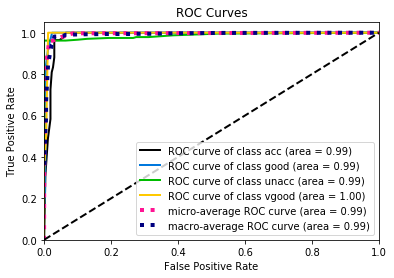

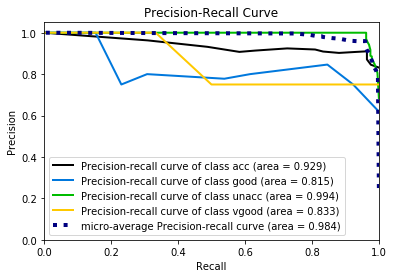

In [19]:
decision_tree=tree.DecisionTreeClassifier(criterion="entropy",
                                          max_depth=10,
                                          min_impurity_decrease=0.005)
print('Final decision tree model \n')
model_fit(decision_tree,x_train,x_test,y_train,y_test)

#### KNN

In [20]:
param_test ={'n_neighbors':list(range(1,20)),
             'weights':('uniform','distance'),
             'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
             'p':(1,2)}
gsearch=GridSearchCV(estimator=neighbors.KNeighborsClassifier(),
                      param_grid=param_test,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
gsearch.fit(x_train,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.9175108538350217
Best parameters: {'algorithm': 'brute', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


KNN model with 9 neighbors

Training Accuracy:  1.0
Testing Accuracy:  0.94  

Kappa Statistic:  0.87  

MCC:  0.87  

Classification Report:
              precision    recall  f1-score   support

         acc       0.86      0.90      0.88        84
        good       0.71      0.38      0.50        13
       unacc       0.98      0.99      0.98       237
       vgood       0.90      0.75      0.82        12

   micro avg       0.94      0.94      0.94       346
   macro avg       0.86      0.76      0.80       346
weighted avg       0.94      0.94      0.94       346

Confusion Matrix: 
Actual           Predicted
       acc  good  unacc  vgood
acc     76     1      6      1
good     8     5      0      0
unacc    2     0    235      0
vgood    2     1      0      9


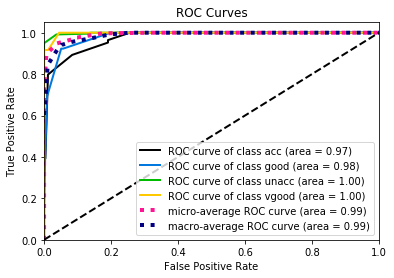

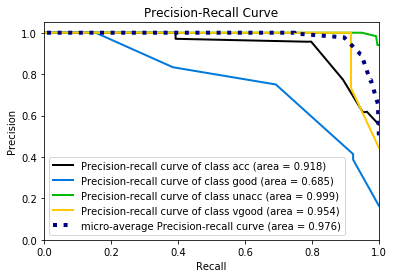

In [21]:
# Model with best parameter
knn=neighbors.KNeighborsClassifier(n_neighbors=9,weights='distance',algorithm='brute',p=1)
print("KNN model with 9 neighbors\n")
model_fit(knn,x_train,x_test,y_train,y_test)

#### Logistic Regression

In [22]:
param_test ={'C':[10,30,40,45, 50],
              'penalty':('l1','l2')}
lr=linear_model.LogisticRegression(random_state=10,multi_class='multinomial',
                                   solver='saga')
gsearch=GridSearchCV(estimator=lr,
                      param_grid=param_test,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
gsearch.fit(x_train,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.9312590448625181
Best parameters: {'C': 45, 'penalty': 'l1'}


Final Logistic regression model 

Training Accuracy:  0.95
Testing Accuracy:  0.93  

Kappa Statistic:  0.86  

MCC:  0.86  

Classification Report:
              precision    recall  f1-score   support

         acc       0.84      0.93      0.88        84
        good       0.92      0.85      0.88        13
       unacc       0.98      0.94      0.96       237
       vgood       0.79      0.92      0.85        12

   micro avg       0.93      0.93      0.93       346
   macro avg       0.88      0.91      0.89       346
weighted avg       0.94      0.93      0.93       346

Confusion Matrix: 
Actual           Predicted
       acc  good  unacc  vgood
acc     78     1      4      1
good     0    11      0      2
unacc   14     0    223      0
vgood    1     0      0     11


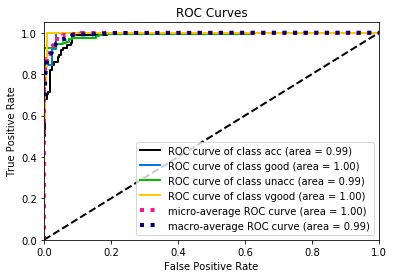

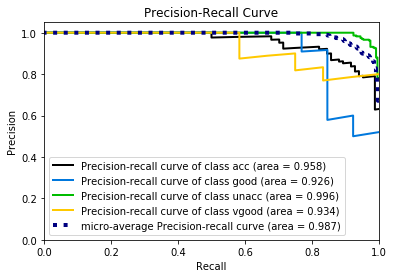

In [23]:
# Model with best parameter
logistic_regression = linear_model.LogisticRegression(C=45,penalty='l1',
                                                      multi_class='multinomial',
                                                      solver='saga')
print('Final Logistic regression model \n')
model_fit(logistic_regression,x_train,x_test,y_train,y_test)

#### Naive Bayes

In [24]:
# Naive Bayes
param_test={'alpha':[1e-10,1e-5,1e-2]}

nb_model = naive_bayes.MultinomialNB()
gsearch=GridSearchCV(estimator=nb_model,
                      param_grid=param_test,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
gsearch.fit(x_train,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8487698986975398
Best parameters: {'alpha': 1e-10}


Final Logistic regression model 

Training Accuracy:  0.87
Testing Accuracy:  0.84  

Kappa Statistic:  0.65  

MCC:  0.66  

Classification Report:
              precision    recall  f1-score   support

         acc       0.70      0.69      0.69        84
        good       0.43      0.23      0.30        13
       unacc       0.91      0.95      0.93       237
       vgood       0.78      0.58      0.67        12

   micro avg       0.84      0.84      0.84       346
   macro avg       0.70      0.61      0.65       346
weighted avg       0.83      0.84      0.84       346

Confusion Matrix: 
Actual           Predicted
       acc  good  unacc  vgood
acc     58     3     23      0
good     8     3      0      2
unacc   13     0    224      0
vgood    4     1      0      7


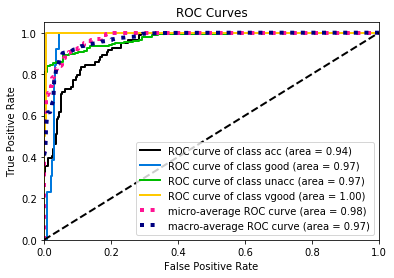

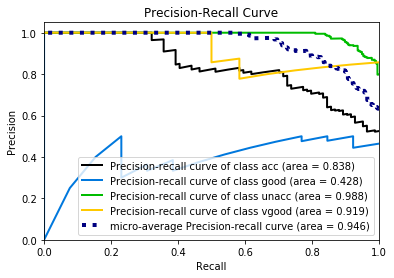

In [25]:
# Model with best parameter
nb_model = naive_bayes.MultinomialNB(alpha=1e-10)
print('Final Logistic regression model \n')
model_fit(nb_model,x_train,x_test,y_train,y_test)

#### Support Vector Machine

In [26]:
param_test={'C':[0.0001,0.001,0.01],
            'kernel':('linear','rbf','poly'),
            'degree':[2,3,4],
            'gamma':[1,5,10,15]}

svm_model = svm.SVC(probability =True)
gsearch=GridSearchCV(estimator=svm_model,
                      param_grid=param_test,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
gsearch.fit(x_train,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.9934876989869754
Best parameters: {'C': 0.0001, 'degree': 4, 'gamma': 5, 'kernel': 'poly'}


Final SVM model 

Training Accuracy:  1.0
Testing Accuracy:  1.0  

Kappa Statistic:  1.0  

MCC:  1.0  

Classification Report:
              precision    recall  f1-score   support

         acc       1.00      1.00      1.00        84
        good       1.00      1.00      1.00        13
       unacc       1.00      1.00      1.00       237
       vgood       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Confusion Matrix: 
Actual           Predicted
       acc  good  unacc  vgood
acc     84     0      0      0
good     0    13      0      0
unacc    0     0    237      0
vgood    0     0      0     12


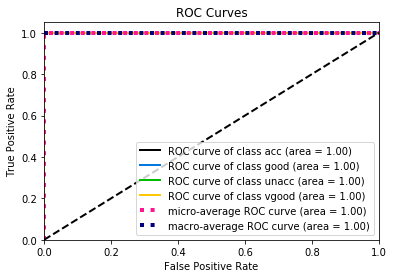

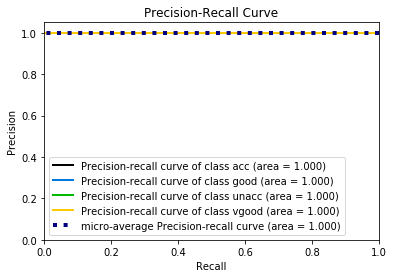

In [27]:
# Model with best parameter
svm_model = svm.SVC(probability =True, 
                    C=0.0001,kernel='poly',
                    degree=4,gamma=5)
print('Final SVM model \n')
model_fit(svm_model,x_train,x_test,y_train,y_test)

#### Nested Cross Valdiation to select best model

In [28]:
# Model comparison
def nested_cv(model,grid,model_name):
    gsearch=GridSearchCV(estimator=model,
                      param_grid=grid,
                      scoring='accuracy',
                      n_jobs=4,
                      iid=True,
                      cv=5)
    nested_score = cross_val_score(gsearch, X=x, y=y, cv=5)
    print(model_name,": Nested cv score is ",
          round(nested_score.mean(),3),
          " +- (",round(nested_score.std(),3),")")

# Nested for Decision tree
param_test={'min_impurity_decrease':list(np.arange(0,.01,0.005)),
             'max_depth':list(range(5,15,2)),
            'criterion':('gini','entropy')}
decision_tree= tree.DecisionTreeClassifier(random_state=10)
nested_cv(decision_tree,param_test,"Decision tree")

# Nested cv for KNN
param_test ={'n_neighbors':list(range(5,15)),
             'weights':('uniform','distance'),
             'algorithm':('auto', 'ball_tree', 'kd_tree'),
             'p':(1,2)}
knn =neighbors.KNeighborsClassifier()
nested_cv(knn,param_test,"KNN")

# Nested cv for Logistic
param_test ={'C':[10,30,40,45,50],
              'penalty':('l1','l2')}
lr=linear_model.LogisticRegression(random_state=10,multi_class='multinomial',
                                   solver='saga')
nested_cv(lr,param_test,"Logistic Regression")

# Nested cv for Naive Bayes
param_test={'alpha':[1e-10,1e-5,1e-2]}
nb_model = naive_bayes.MultinomialNB()
nested_cv(nb_model,param_test,"Naive Bayes")

# Nested cv for SVM
param_test={'C':[0.0001,0.001,0.01],
            'kernel':('linear','rbf','poly'),
            'degree':[3,4],
            'gamma':[1,5,10]}

svm_model = svm.SVC(probability =True)
nested_cv(svm_model,param_test, "Support Vector Machine")

Decision tree : Nested cv score is  0.793  +- ( 0.069 )
KNN : Nested cv score is  0.753  +- ( 0.104 )
Logistic Regression : Nested cv score is  0.775  +- ( 0.057 )
Naive Bayes : Nested cv score is  0.758  +- ( 0.079 )
Support Vector Machine : Nested cv score is  0.905  +- ( 0.049 )


#### Model Comparison based on nested cv

| Model Name | CV Score  
| --- | ---
| Decision Tree | 79.3% +- (6.9%) 
| KNN | 75.3% +- (10.4%) 
| Logistic | 77.5% +- (5.7%) 
| Naive Bayes | 75.8% +- (7.9%) 
| SVM | 90.5% +- (4.9%) 

SVM outperforms every other algorithm by considerale margin.